In [1]:
import json

notebook_file = "/home/ryounis/Documents/Zurich/PEACHLab/datascience-visualisation/data/datasets/Natural Language Processing with Disaster Tweets/classified_notebooks.json"
with open(notebook_file, 'r') as file:
    data = json.load(file)
LABELS = data["metadata"]["labels"]

In [2]:
import os
import sys; sys.path.insert(0, "../")
from Clusterers.clusterer import ClassCluster
from tqdm import tqdm

with open('../../../secrets/api_key.txt', 'r') as f: api_key = f'{f.read()}'

os.environ["OPENAI_API_KEY"] = api_key
clusterer = ClassCluster()
grouped_cells = {label: [] for label in LABELS}
for notebook in tqdm(data["notebooks"]):
    for cell in notebook["cells"]:
        cell["embedding"] = clusterer.embed_cell(cell["code"], cell["desc"])
        grouped_cells[cell["class"]].append(cell)
        
for label, cells in grouped_cells.items():
    print(f'{label}: {len(cells)}')

/home/ryounis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 28/28 [02:11<00:00,  4.69s/it]

Data_Transform: 246
Data_Extraction: 55
Visualization: 82
Model_Train: 120
Model_Evaluation: 88
Imports_and_Environment: 80
Data_Export: 38
Exploratory_Data_Analysis: 173


In [3]:
cells = grouped_cells["Data_Transform"]

In [25]:
import numpy as np

embeddings = np.array([cell["embedding"] for cell in cells])

In [148]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, perplexity=30, n_iter=3000)
reduced_embeddings = tsne.fit_transform(embeddings)
reduced_embeddings

/home/ryounis/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


array([[ 7.69970627e+01,  4.69297829e+01, -1.03947327e+02],
       [ 3.44259872e+01,  1.99340935e+01, -1.14246597e+01],
       [ 4.97892647e+01,  2.73454399e+01, -1.94108372e+01],
       [ 3.69466324e+01,  5.09956658e-01,  1.05767624e+02],
       [ 5.93918839e+01, -5.76850853e+01,  8.67257309e+01],
       [ 3.09065113e+01,  1.07027245e+01,  7.69335861e+01],
       [-8.51089859e+01,  1.86005173e+01, -2.14670110e+00],
       [ 6.56811295e+01, -4.97877045e+01,  1.07052216e+02],
       [ 2.15507698e+01, -5.54251137e+01,  7.25516891e+01],
       [-2.50727806e+01,  4.37148247e+01,  9.83717651e+01],
       [-8.65672684e+01,  7.06314278e+00,  3.02379761e+01],
       [-8.53290253e+01, -6.65588140e+00,  1.16133041e+01],
       [-3.04948177e+01,  2.70016117e+01, -2.67363243e+01],
       [ 1.50319433e+00,  1.78893642e+01, -2.59520721e+01],
       [ 3.85846996e+00, -1.13965202e+02, -2.99622574e+01],
       [-1.38875151e+01,  2.39914169e+01,  7.97255554e+01],
       [ 2.76113930e+01, -7.61690378e+00

In [136]:
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA(n_components=0.9)

# Fit the PCA model to the embeddings
reduced_embeddings = pca.fit_transform(embeddings)

# Print the shape of the reduced embeddings
print(reduced_embeddings.shape)

(246, 43)


In [149]:
from sklearn.cluster import HDBSCAN
import numpy as np
import sklearn.metrics.pairwise as pairwise
 
# reduced_embeddings = pairwise.cosine_distances(reduced_embeddings)
clusterer = HDBSCAN(
    min_cluster_size=10,
    min_samples=2,
    cluster_selection_epsilon=0,
    max_cluster_size=None,
    alpha=1,
    # metric="precomputed"
)

clusterer.fit(reduced_embeddings)
labels = clusterer.labels_
for i, n in  enumerate(np.bincount([label+1 for label in labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 64
Cluster 0: 47
Cluster 1: 11
Cluster 2: 50
Cluster 3: 25
Cluster 4: 29
Cluster 5: 20


In [150]:
cluster_indices = np.where(labels == -1)[0]
cluster_points = reduced_embeddings[cluster_indices]
cluster_points = pairwise.cosine_distances(cluster_points)
clusterer.fit(cluster_points)
outlier_labels = clusterer.labels_
for i, n in  enumerate(np.bincount([label+1 for label in outlier_labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 3
Cluster 0: 51
Cluster 1: 10


In [151]:
max_cluster = max(labels)+1
for i, idx in enumerate(cluster_indices):
    if outlier_labels[i] != -1:
        labels[idx] = max_cluster + outlier_labels[i]

for i, n in  enumerate(np.bincount([label+1 for label in labels])):
    print(f"Cluster {i-1}: {n}")

Cluster -1: 3
Cluster 0: 47
Cluster 1: 11
Cluster 2: 50
Cluster 3: 25
Cluster 4: 29
Cluster 5: 20
Cluster 6: 51
Cluster 7: 10


In [152]:
from Clusterers.title_generator import TitleGenerator

title_generator = TitleGenerator()
descs = [cell["desc"] for cell in cells]
titles = title_generator.generate_titles_from_descs(labels, descs)
titles

100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


{'0': 'Text Data Processing and Preparation',
 '1': 'Data Preparation and Splitting for Training',
 '2': 'Text Data Preprocessing for NLP Tasks',
 '3': 'Text Data Preprocessing and Encoding Techniques',
 '4': 'Text Preprocessing and Feature Engineering Techniques',
 '5': 'Comprehensive Text Preprocessing in DataFrames',
 '6': 'Text Data Preprocessing and Splitting',
 '7': 'Text Data Vectorization and Encoding Techniques',
 '-1': 'Text Preprocessing and TensorFlow Dataset Preparation'}

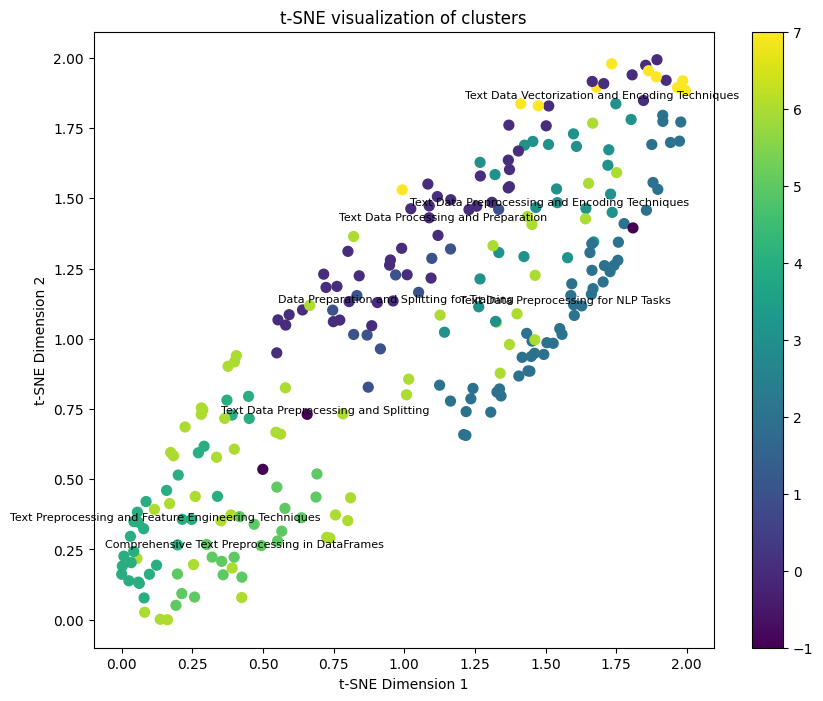

In [153]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add titles for each cluster
for i, label in enumerate(np.unique(labels)):
    if label != -1:
        plt.text(reduced_embeddings[labels == label, 0].mean(), reduced_embeddings[labels == label, 1].mean(), titles[str(label)], fontsize=8, ha='center', va='center')

plt.show()

In [154]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(reduced_embeddings, labels)
ch_index = calinski_harabasz_score(reduced_embeddings, labels)
db_index = davies_bouldin_score(reduced_embeddings, labels)
print(f"Silhouette Score:           {sil_score} (how similar a point is to its own cluster (cohesion) compared to other clusters (separation))")
print(f"Calinski-Harabasz Index:    {ch_index} (ratio of the sum of between-cluster dispersion and within-cluster dispersion)")
print(f"Davies-Bouldin Index:       {db_index} (average similarity ratio of each cluster with the cluster that is most similar to it)")

Silhouette Score:           0.2244683802127838 (how similar a point is to its own cluster (cohesion) compared to other clusters (separation))
Calinski-Harabasz Index:    64.56541691030544 (ratio of the sum of between-cluster dispersion and within-cluster dispersion)
Davies-Bouldin Index:       1.6656460803372866 (average similarity ratio of each cluster with the cluster that is most similar to it)


In [68]:
import pandas as pd

# Create a list to store the data
data = []

# Iterate over the cells
for i, cell in enumerate(cells):
    # Get the code, description, cluster, and title
    code = cell["code"]
    desc = cell["desc"]
    cluster = labels[i]
    title = titles[str(labels[i])]

    # Append the data to the list
    data.append([code, desc, cluster, title])

# Create the dataframe
df = pd.DataFrame(data, columns=["Code", "Description", "Cluster", "Title"])
df

,Code,Description,Cluster,Title
0,"train_df = train_df.drop(columns=[""id"", ""keywo...","This code snippet drops the ""id"", ""keyword"", a...",-1,Text Data Preprocessing and Analysis
1,def remove_URL(text):\n url = re.compile(r'...,This code snippet defines a function to remove...,6,Text Data Cleaning and Vectorization Techniques
2,def remove_html(text):\n html=re.compile(r'...,This code snippet defines a function to remove...,6,Text Data Cleaning and Vectorization Techniques
3,def remove_emoji(text):\n emoji_pattern = r...,This code snippet defines a function to remove...,0,Text Preprocessing for Machine Learning Models
4,"train_tensor = tokenizer(list(train_df[""text""]...",This code snippet tokenizes the text data from...,0,Text Preprocessing for Machine Learning Models
...,...,...,...,...
241,word2vec_X = X[0:train_data.shape[0]]\ny = dat...,This code snippet splits the array `X` back in...,0,Text Preprocessing for Machine Learning Models
242,tokenizer = Tokenizer()\ntokenizer.fit_on_text...,This code snippet tokenizes the texts in `data...,6,Text Data Cleaning and Vectorization Techniques
243,trainCNN_data = cnn_data[0:train_data.shape[0]...,This code snippet splits the CNN-ready data an...,0,Text Preprocessing for Machine Learning Models
244,embedding_matrix = np.zeros((len(word_index) +...,This code snippet initializes an embedding mat...,6,Text Data Cleaning and Vectorization Techniques
